In [490]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#So first we will need to collate all the data for the different variables that we are considering. 
#duration that we are looking for will be from 2015-01-01 to 2025-01-01
#will have to ensure all data is available within this period stipulated to predict 2025-02-01 total housing starts
#As the data found are of different frequencies and different end dates, extrapolation and interpolation has to be done

          date  Total Housing Starts  PPI by Deep Sea Freight  \
116 2024-09-01                1355.0                  414.282   
117 2024-10-01                1344.0                  410.830   
118 2024-11-01                1305.0                  391.288   
119 2024-12-01                1515.0                  388.204   
120 2025-01-01                1366.0                  378.846   

     PPI by Truckload  Household Estimates  
116           175.155             132508.0  
117           175.660             132533.0  
118           176.842             132405.0  
119           182.480             132276.0  
120           183.010                  NaN  


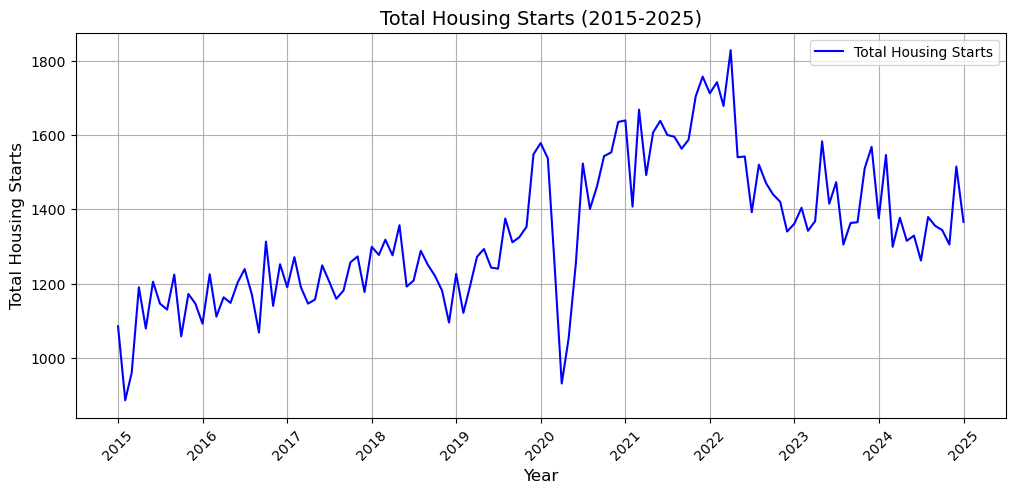

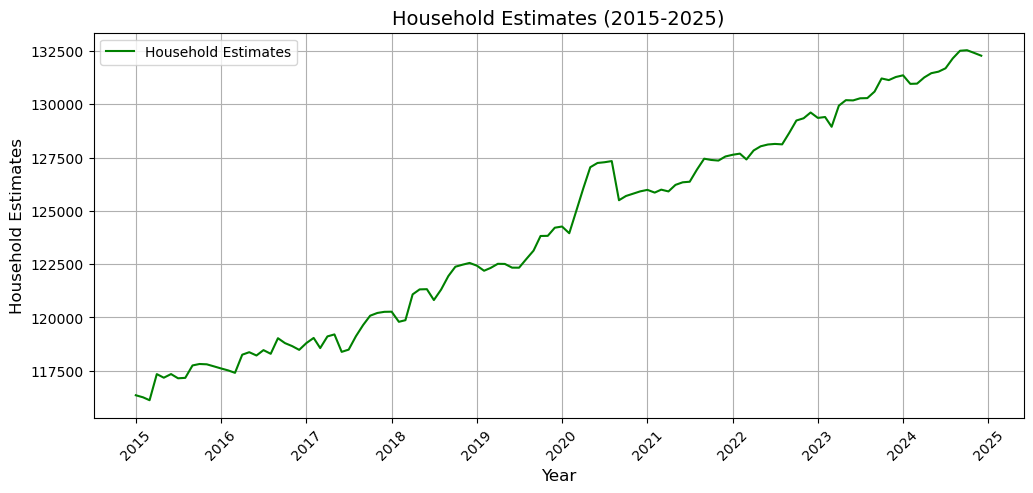

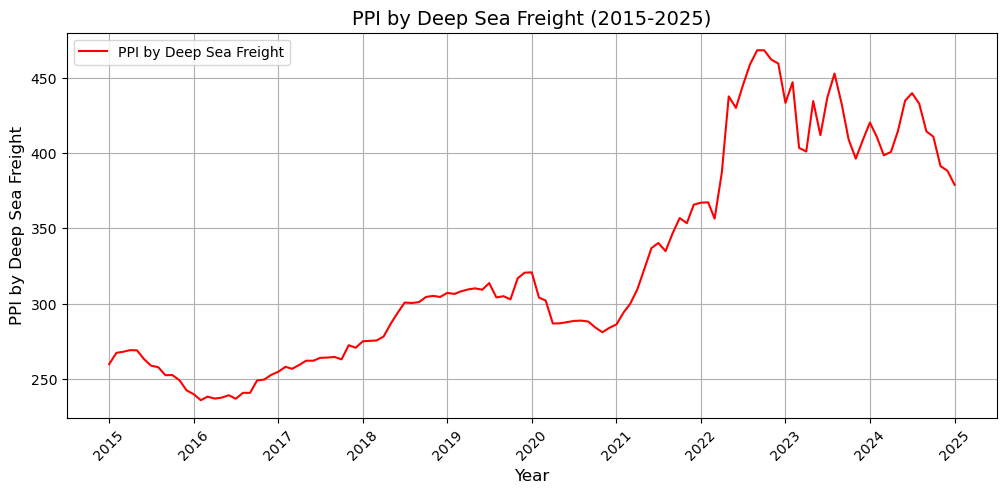

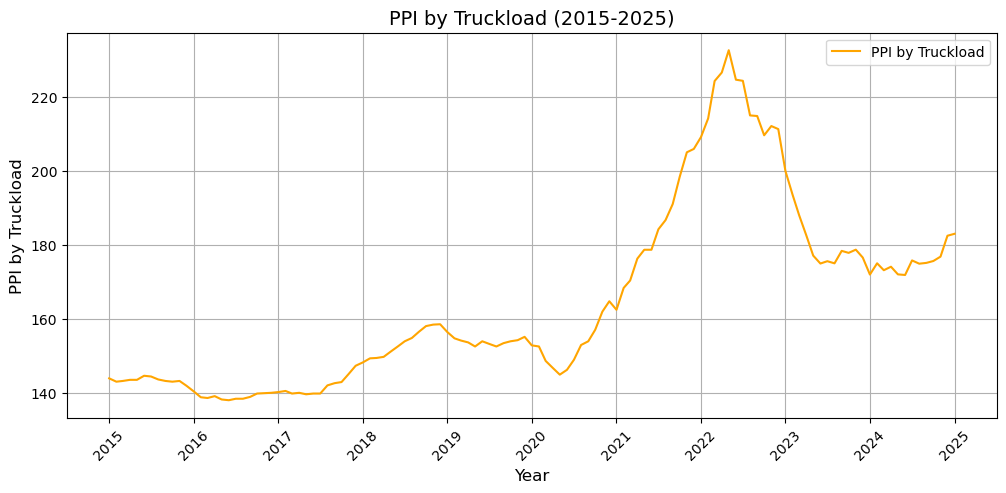

In [578]:
#focus is on the last 10 years starting from 2015 and on a monthly basis
#household estimates  = basically the number of households in US
#PPI for deep sea freights and truckhold are basically transportation costs for construction materials
#total housing starts is the variable we are trying to predict here
#we will extrapolate all the data up to 2025 June just so that we can visualise the relative accuracy of the data
df = pd.read_csv("/Users/benwong/Downloads/point72casestudy/monthly.csv")
df["observation_date"] = pd.to_datetime(df["observation_date"])
df = df.rename(columns={
    "observation_date": "date",
    "HOUST": "Total Housing Starts",
    "PCU483111483111": "PPI by Deep Sea Freight",
    "PCU4841214841212": "PPI by Truckload",
    "TTLHHM156N": "Household Estimates"
})
# Filter data from January 2015 to February 2025
df_filtered = df.loc[(df['date'] >= "2015-01-01") & (df['date'] <= "2025-02-01")].reset_index(drop=True)
print(df_filtered.tail())
# Plot the graphs for the different variables to visualise the trend
variables = ["Total Housing Starts", "Household Estimates", "PPI by Deep Sea Freight", "PPI by Truckload"]
colors = ["blue", "green", "red", "orange"]
for var, color in zip(variables, colors):
    plt.figure(figsize=(12, 5))
    plt.plot(df_filtered["date"], df_filtered[var], color=color, label=var)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Show every 1 year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as Year
    plt.title(f"{var} (2015-2025)", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel(var, fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

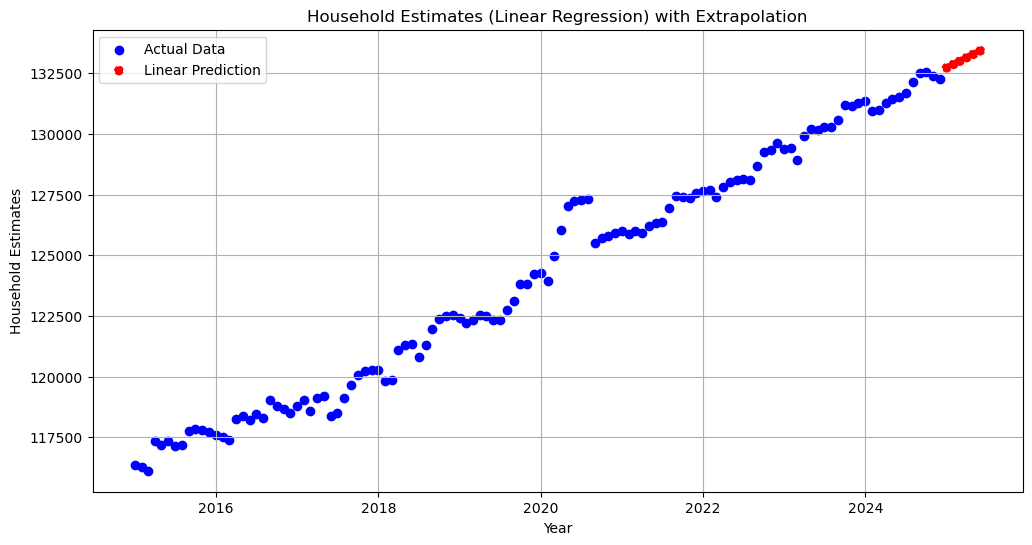

In [882]:
#Since data for household estimates in the US for 2025 Jan is missing and we need to extrapolate data for Feb 2025 for all of them,
# We first start off with the extrapolation for household estimates
# The graph looks relatively linear in my opinion, hence for this, I will use a linear regression method to extrapolate for the data
# will extrapolate for the next 5 months just so that I can see if the trend makes sense visually
# Prepare features (X) and target (y)
df_household = df_filtered.loc[df_filtered['date'] <= "2024-12-01"].reset_index(drop=True)
df_household["date_ordinal"] = df_household["date"].apply(lambda x: x.toordinal())
X = df_household["date_ordinal"].values.reshape(-1, 1)  # Feature: Date as numerical values
y = df_household["Household Estimates"].values  # Target: Household Estimates

# Fit Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict future values for the next 6 months up to June 2025
future_dates = pd.date_range(start="2025-01-01", periods=6, freq="MS")
future_ordinal = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
future_predictions = model.predict(future_ordinal)

#Plot final results with extrapolation
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered["date"], df_filtered["Household Estimates"], color="blue", label="Actual Data")
plt.scatter(future_dates, future_predictions, color="red", linestyle="dashed", label="Linear Prediction")
plt.xlabel("Year")
plt.ylabel("Household Estimates")
plt.title("Household Estimates (Linear Regression) with Extrapolation")
plt.legend()
plt.grid(True)
plt.show()
#keep the forecasted data first
HEforecast = pd.DataFrame({'date': future_dates, 'Household Estimates': future_predictions})
HEforecast.set_index('date', inplace=True)


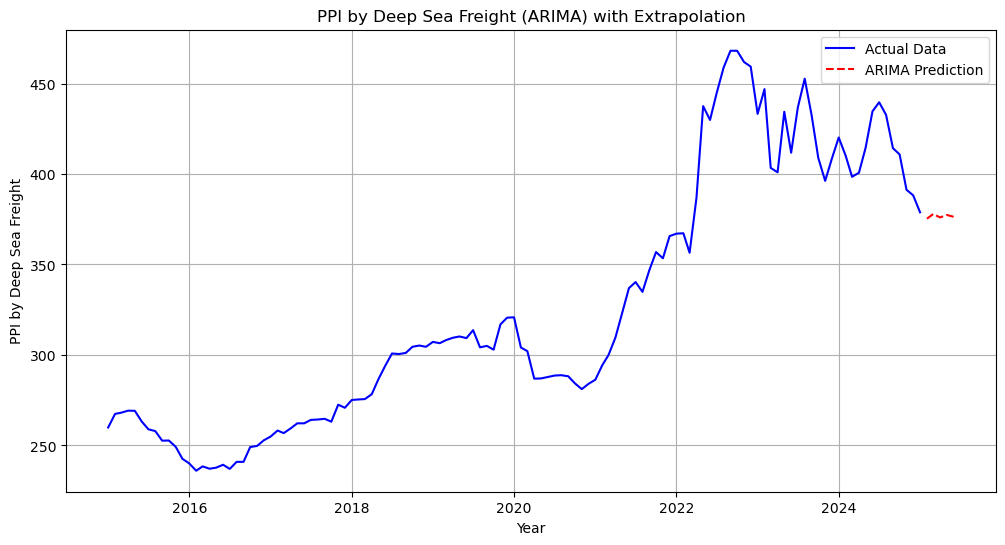

In [678]:
#Since there is no obvious seasonality for PPI deep sea freights, I am going to use ARIMA model to deal with this non-linear trend
#I did try cubic polynomial regression but failed as the data that came out was too weird

df_filtered["date"] = pd.to_datetime(df_filtered["date"])
df_filtered = df_filtered.sort_values(by="date")
df_ppi = df_filtered.loc[df_filtered['date'] <= "2025-01-01"].set_index("date")
df_ppi = df_ppi.asfreq("MS") 

# Fitting of the ARIMA model to extrapolate for the data for the next 5 months up to June 2025
model_arima = sm.tsa.ARIMA(df_ppi["PPI by Deep Sea Freight"], order=(1,1,1))
arima_results = model_arima.fit()
future_steps = 5
future_dates = pd.date_range(start="2025-02-01", periods=future_steps, freq="MS")
forecast_arima = arima_results.forecast(steps=future_steps)

#Plot final results with extrapolation
plt.figure(figsize=(12, 6))
plt.plot(df_ppi.index, df_ppi["PPI by Deep Sea Freight"], label="Actual Data", color="blue")
plt.plot(future_dates, forecast_arima, linestyle="dashed", color="red", label="ARIMA Prediction")
plt.xlabel("Year")
plt.ylabel("PPI by Deep Sea Freight")
plt.title("PPI by Deep Sea Freight (ARIMA) with Extrapolation")
plt.legend()
plt.grid(True)
plt.show()

# Convert forecast to DataFrame to combine later
DSforecast = pd.DataFrame({'date': future_dates, 'PPI by Deep Sea Freight': forecast_arima})
DSforecast.set_index('date', inplace=True)

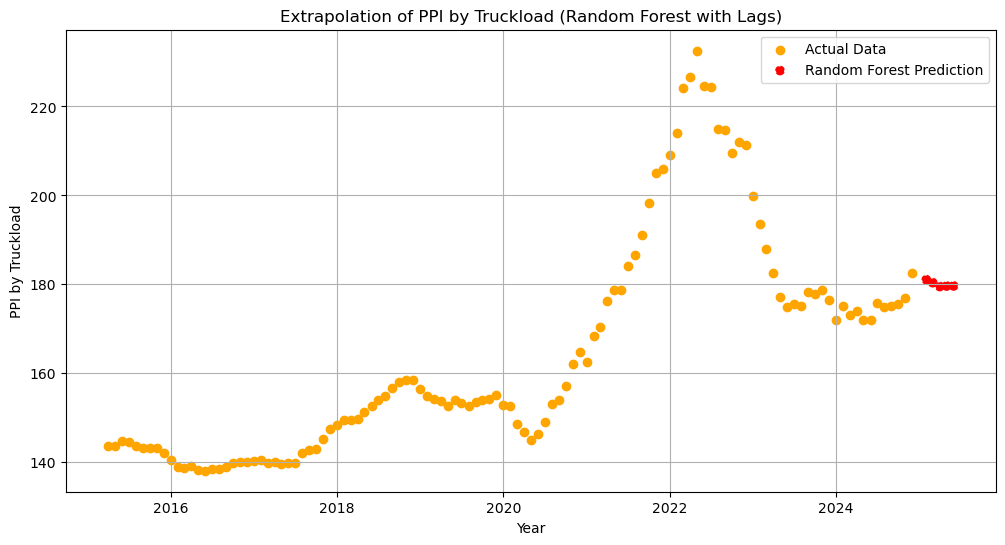

In [722]:
#Now looking at the PPI by truckload data, we can see sudden random shifts
#with 2020-2022 (sharp increases)and 2023 (sharp decreases)
#Hence in my opinion, a random forest regression is most suitable here since there may be other external factors affecting it
#like supply chain disruption, oil prices, wars, covid etc
#However, the usual randomforestregressor produces data that is too flat in my opinion and doesnt factor in the more recent data
#when it performs its forecasting
#Therefore, i included more lag features to help it learn from its past trends 
# and increased the tree depth to better capture non-linearity
from sklearn.ensemble import RandomForestRegressor
df_filtered["date"] = pd.to_datetime(df_filtered["date"])
df_filtered = df_filtered.sort_values(by="date")

# Filter data up to Jan 2025
dftruck = df_filtered.loc[df_filtered['date'] <= "2025-01-01"].reset_index(drop=True)
dftruck["date_ordinal"] = dftruck["date"].apply(lambda x: x.toordinal())

# Create lag features by using past 3 months' data to predict the next
dftruck["lag_1"] = dftruck["PPI by Truckload"].shift(1)
dftruck["lag_2"] = dftruck["PPI by Truckload"].shift(2)
dftruck["lag_3"] = dftruck["PPI by Truckload"].shift(3)
dftruck.dropna(inplace=True)  # Drop rows with NaNs from lagging

# Fit Random Forest Regression model with more estimators and start predicting future values for the next 5 months
# using the lagging values to predict iteratively
X = dftruck[["date_ordinal", "lag_1", "lag_2", "lag_3"]]
y = dftruck["PPI by Truckload"]
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf_model.fit(X, y)

# Create future date range (Feb 2025 - June 2025)
truckfuture = pd.date_range(start="2025-02-01", periods=5, freq="MS")
truckfuture = pd.DataFrame({'date': truckfuture})
truckfuture["date_ordinal"] = truckfuture["date"].apply(lambda x: x.toordinal())

# Initialize lag values from the most recent real data
last_values = dftruck.iloc[-1][["PPI by Truckload", "lag_1", "lag_2"]].values  # Fix index issue

# Predict iteratively (use previous predictions as future lag values)
future_predictions = []
for i in range(5):
    truckfuture.loc[i, "lag_1"] = last_values[0]
    truckfuture.loc[i, "lag_2"] = last_values[1]
    truckfuture.loc[i, "lag_3"] = last_values[2]
    pred = rf_model.predict(truckfuture.iloc[[i]][["date_ordinal", "lag_1", "lag_2", "lag_3"]])[0]
    future_predictions.append(pred)
    last_values = [pred, last_values[0], last_values[1]]

# Convert forecast to DataFrame
truckforecast = pd.DataFrame({'date': truckfuture["date"], 'PPI by Truckload': future_predictions})

#Plot final results with extrapolation
plt.figure(figsize=(12, 6))
plt.scatter(dftruck["date"], dftruck["PPI by Truckload"], color="orange", label="Actual Data")
plt.scatter(truckforecast["date"], truckforecast["PPI by Truckload"], color="red", linestyle="dashed", label="Random Forest Prediction")
plt.xlabel("Year")
plt.ylabel("PPI by Truckload")
plt.title("Extrapolation of PPI by Truckload (Random Forest with Lags)")
plt.legend()
plt.grid(True)
plt.show()


In [734]:
#Now I merge the forecasted dataframes all together for easy use later
if 'date' not in truckforecast.columns:
    truckforecast = truckforecast.reset_index()
if 'date' not in HEforecast.columns:
    HEforecast = HEforecast.reset_index()
if 'date' not in DSforecast.columns:
    DSforecast = DSforecast.reset_index()
combined_forecast = truckforecast.merge(HEforecast, on="date", how="outer")
combined_forecast = combined_forecast.merge(DSforecast, on="date", how="outer")
combined_forecast.set_index('date', inplace=True)
df_merged = df_filtered.copy()
df_merged.set_index("date", inplace=True)
df_merged.update(combined_forecast)
df_merged = pd.concat([df_merged, combined_forecast[~combined_forecast.index.isin(df_merged.index)]], axis=0)
df_merged = df_merged.drop(columns=['index_x','level_0_x','index_y','level_0_y','index'])
df_merged = df_merged.reset_index().sort_values(by="date")
print(df_merged.tail(10))

          date  Total Housing Starts  PPI by Deep Sea Freight  \
116 2024-09-01                1355.0               414.282000   
117 2024-10-01                1344.0               410.830000   
118 2024-11-01                1305.0               391.288000   
119 2024-12-01                1515.0               388.204000   
120 2025-01-01                1366.0               378.846000   
121 2025-02-01                   NaN               375.293300   
122 2025-03-01                   NaN               377.886699   
123 2025-04-01                   NaN               375.993570   
124 2025-05-01                   NaN               377.375516   
125 2025-06-01                   NaN               376.366723   

     PPI by Truckload  Household Estimates  
116        175.155000        132508.000000  
117        175.660000        132533.000000  
118        176.842000        132405.000000  
119        182.480000        132276.000000  
120        183.010000        132726.872865  
121        181

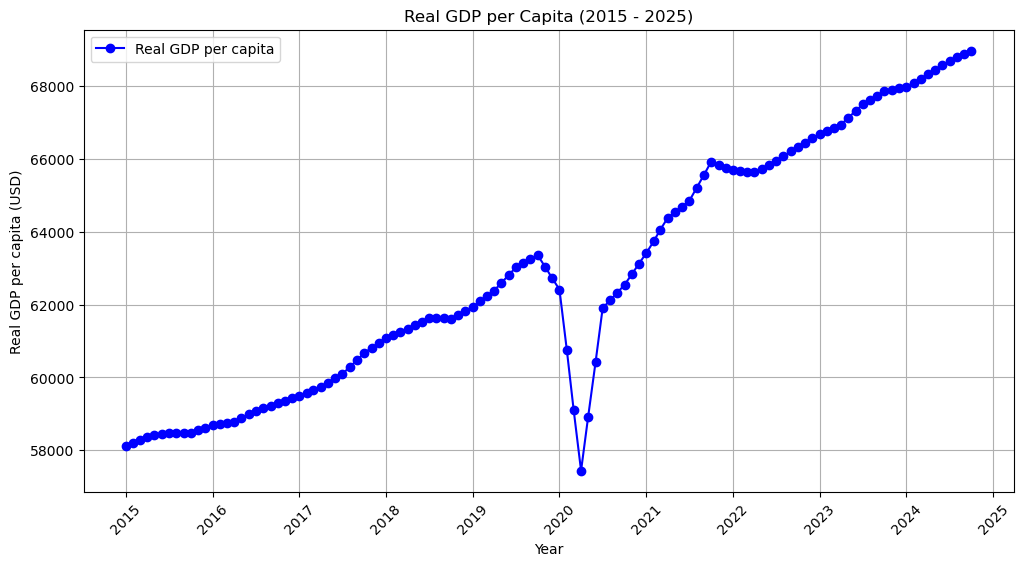

In [1249]:
#Moving onto GDP per capital, as the data lies on a different dataframe and it is of a quarterly basis initially
#Interpolation and extrapolation has to be done to fill in the data on a monthly basis up to June 2025
gdp = pd.read_csv("/Users/benwong/Downloads/point72casestudy/realgdppercapita.csv")
gdp = gdp.rename(columns = {"observation_date": "date", "A939RX0Q048SBEA": "Real GDP per capita"})
gdp['date'] = pd.to_datetime(gdp['date'])  # Ensure correct format
gdp = gdp.loc[(gdp['date'] >= "2015-01-01") & (gdp['date'] <= "2025-02-01")]
gdp = gdp.reset_index(drop=True)
# Resample to monthly frequency and interpolate missing values
gdp = gdp.set_index('date').resample('MS').interpolate(method='linear').reset_index()

# Plot the GDP data to determine which regression is suitable for the extrapolation method
plt.figure(figsize=(12, 6))
plt.plot(gdp['date'], gdp['Real GDP per capita'], color="blue", marker='o', linestyle="-", label="Real GDP per capita")
plt.xlabel("Year")
plt.ylabel("Real GDP per capita (USD)")
plt.title("Real GDP per Capita (2015 - 2025)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


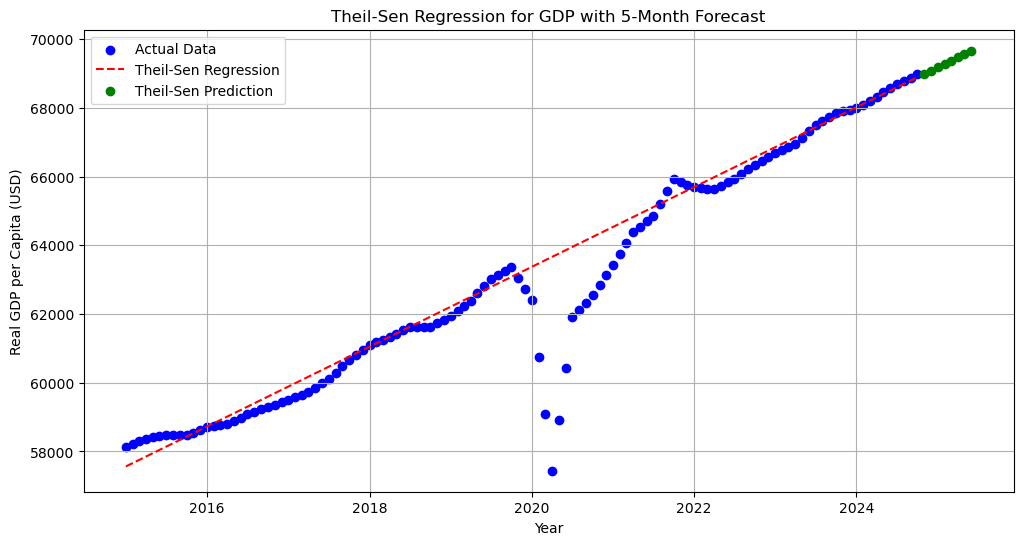

          date  Real GDP per capita
116 2024-09-01         68880.000000
117 2024-10-01         68972.000000
118 2024-11-01         68985.993124
119 2024-12-01         69081.380267
120 2025-01-01         69179.946980
121 2025-02-01         69278.513694
122 2025-03-01         69367.541693
123 2025-04-01         69466.108406
124 2025-05-01         69561.495549
125 2025-06-01         69660.062262


In [1121]:
#As observed above, there was a sharp decrease in real gdp per capita in 2020 as a result of covid 19
#this is an anomaly hence i am looking to downweight this drop created by the rare event (covid 19)
# hence i will be using Theil-Sen Regression as outside of the drop in 2020, 
# the regression looks linear and it allows me to downweight this outlier while maintaining a linear regression model
from sklearn.linear_model import TheilSenRegressor

gdp["date_ordinal"] = gdp["date"].apply(lambda x: x.toordinal())  # Convert date to numeric
X = gdp["date_ordinal"].values.reshape(-1, 1)
y = gdp["Real GDP per capita"].values

# Fitting of the Theil-Sen Regression to predict for the next 8 months (Nov 2024 - June 2025)
theil_sen = TheilSenRegressor()
theil_sen.fit(X, y)
y_pred = theil_sen.predict(X)
future_dates = pd.date_range(start="2024-11-01", periods=8, freq="MS")
future_ordinal = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
future_predictions = theil_sen.predict(future_ordinal)

#Plot final results with extrapolation
plt.figure(figsize=(12, 6))
plt.scatter(gdp["date"], gdp["Real GDP per capita"], color="blue", label="Actual Data")
plt.plot(gdp["date"], y_pred, color="red", linestyle="dashed", label="Theil-Sen Regression")
plt.scatter(future_dates, future_predictions, color="green", marker="o", label="Theil-Sen Prediction")
plt.xlabel("Year")
plt.ylabel("Real GDP per Capita (USD)")
plt.title("Theil-Sen Regression for GDP with 5-Month Forecast")
plt.legend()
plt.grid(True)
plt.show()

# Convert forecast to DataFrame to combine later
gdp_forecast = pd.DataFrame({'date': future_dates, 'Real GDP per capita': future_predictions})
gdpwithforecast = pd.concat([gdp, gdp_forecast], ignore_index=True).sort_values(by="date")
gdpwithforecast = gdpwithforecast.drop(columns = ["date_ordinal"])
print(gdpwithforecast.tail(10))

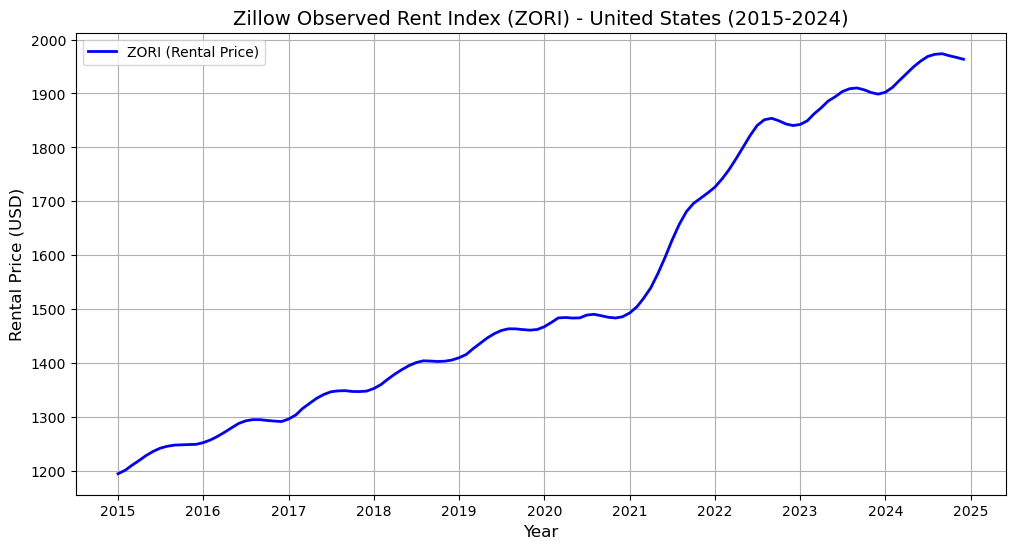

In [846]:
#Zillow Observed Rent Index (ZORI) 
#needed to invert the graph as the data provided had the dates as the column indexes
# Load and preprocess the data
zori = pd.read_csv("/Users/benwong/Downloads/point72casestudy/ZORI_rentaldata.csv")
zori = zori[zori["RegionName"] == "United States"]
zori_melted = zori.melt(
    id_vars=["RegionID", "SizeRank", "RegionName", "RegionType", "StateName"],
    var_name="Date",
    value_name="Rental Price"
)
zori_melted["Date"] = pd.to_datetime(zori_melted["Date"])
zori_melted = zori_melted.rename(columns={"Date": "date"})
zori_melted = zori_melted[(zori_melted["date"] >= "2015-01-01") & (zori_melted["date"] <= "2024-12-31")]
zori_melted = zori_melted.set_index("date")
zori_melted = zori_melted.drop(columns=["RegionID", "SizeRank", "RegionName", "RegionType", "StateName"])

# Resample to monthly frequency
zori_melted = zori_melted.resample("MS").mean().interpolate(method='linear')

#Plot the graph to view the trend
plt.figure(figsize=(12, 6))
plt.plot(zori_melted.index, zori_melted["Rental Price"], label="ZORI (Rental Price)", color="blue", linewidth=2)
plt.title("Zillow Observed Rent Index (ZORI) - United States (2015-2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rental Price (USD)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

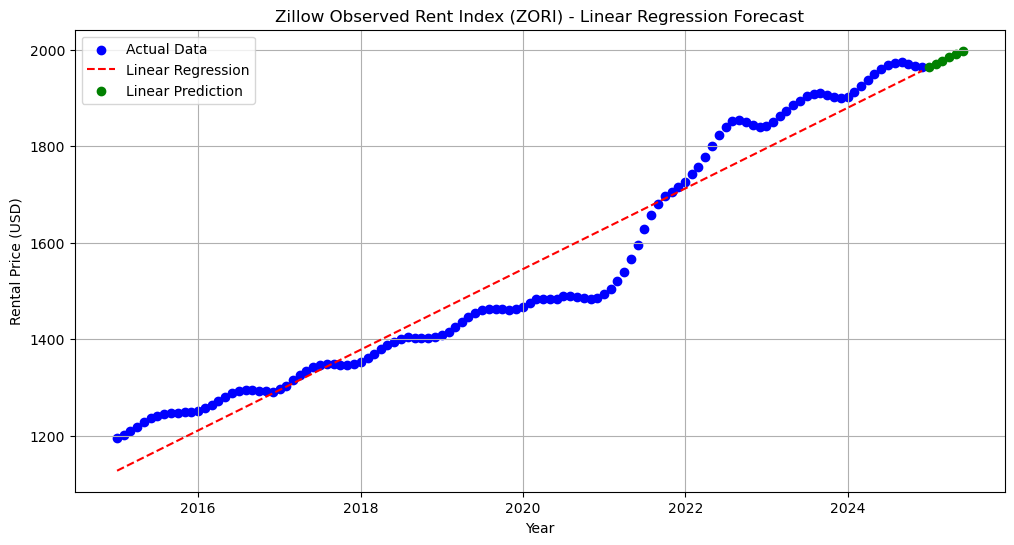

          date  Rental Price
116 2024-09-01   1973.722920
117 2024-10-01   1969.977831
118 2024-11-01   1966.849402
119 2024-12-01   1963.425739
120 2025-01-01   1963.173661
121 2025-02-01   1970.261566
122 2025-03-01   1976.663543
123 2025-04-01   1983.751448
124 2025-05-01   1990.610710
125 2025-06-01   1997.698614


In [850]:
#Since data looks relatively linear, I will perform linear regression
#Convert the date column to ordinal format for regression
zori_melted = zori_melted.reset_index()
zori_melted["date_ordinal"] = zori_melted["date"].map(lambda x: x.toordinal())

# Prepare the regression model
X = zori_melted["date_ordinal"].values.reshape(-1, 1)
y = zori_melted["Rental Price"].values
lr_model = LinearRegression()
lr_model.fit(X, y)
y_pred = lr_model.predict(X)

# Predict for the next 6 months (Jan 2025 - June 2025)
future_dates = pd.date_range(start="2025-01-01", periods=6, freq="MS")
future_ordinal = np.array([d.toordinal() for d in future_dates]).reshape(-1, 1)
future_predictions = lr_model.predict(future_ordinal)

# Convert forecast to DataFrame
zori_forecast = pd.DataFrame({'date': future_dates, 'Rental Price': future_predictions})

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(zori_melted["date"], zori_melted["Rental Price"], color="blue", label="Actual Data")
plt.plot(zori_melted["date"], y_pred, color="red", linestyle="dashed", label="Linear Regression")
plt.scatter(future_dates, future_predictions, color="green", marker="o", label="Linear Prediction")
plt.xlabel("Year")
plt.ylabel("Rental Price (USD)")
plt.title("Zillow Observed Rent Index (ZORI) - Linear Regression Forecast")
plt.legend()
plt.grid(True)
plt.show()

# Merge forecast with original dataset
zori_combined = pd.concat([zori_melted, zori_forecast], ignore_index=True)
zori_combined = zori_combined.sort_values(by="date").reset_index(drop=True)
zori_combined = zori_combined.drop(columns = ['date_ordinal','index'])
print(zori_combined.tail(10))

In [1145]:
#median multiple data(MMP) is not available on FRED so I will have to count for it manually
#MMP = median housing prices (MHP)/ median household income (MHI)
#problem here identified was that it only had data up until january 2023
#will have to intrapolate data in between to make it monthly and extrapolate data to fit up to January 2025
# When observing median housing prices (below as you can see in the combined graph with the forecast),
# the graph shows a linear trend hence MHI will be forecasted with a linear regression
# for MHP it shows a clear long term upward trend, but its non-linear, so I will use Holt-Winters regression
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Filtering of MHP and MHI data
MHP = pd.read_csv("/Users/benwong/Downloads/point72casestudy/mediansalespriceushouses.csv")
MHP = MHP.rename(columns={"observation_date": "date", "MSPUS": "Median Housing Prices"})
MHP['date'] = pd.to_datetime(MHP['date'])
MHP = MHP[(MHP['date'] >= "2015-01-01") & (MHP['date'] <= "2024-10-01")]
MHI = pd.read_csv("/Users/benwong/Downloads/point72casestudy/usmedianhouseholdincome.csv")
MHI = MHI.rename(columns={"observation_date": "date", "MEHOINUSA646N": "Median Household Income"})
MHI['date'] = pd.to_datetime(MHI['date'])
MHI = MHI[(MHI['date'] >= "2015-01-01") & (MHI['date'] <= "2023-01-01")]

# Interpolate MHI to monthly frequency and forecast MHI using Linear Regression
MHI = MHI.set_index('date').resample('MS').interpolate(method='linear').reset_index()
MHI["date_ordinal"] = MHI["date"].apply(lambda x: x.toordinal())
X_mhi = MHI["date_ordinal"].values.reshape(-1, 1)
y_mhi = MHI["Median Household Income"].values
lr_mhi = LinearRegression()
lr_mhi.fit(X_mhi, y_mhi)
future_dates_mhi = pd.date_range(start="2023-02-01", periods=29, freq="MS")  # Forecast until June 2025
future_ordinal_mhi = np.array([d.toordinal() for d in future_dates_mhi]).reshape(-1, 1)
future_mhi_pred = lr_mhi.predict(future_ordinal_mhi)
MHI_forecast = pd.DataFrame({'date': future_dates_mhi, 'Median Household Income': future_mhi_pred})
MHI = pd.concat([MHI, MHI_forecast], ignore_index=True)

# Interpolate MHP to monthly frequency and forecast MHP using Holt-Winters
MHP = MHP.set_index('date').resample('MS').interpolate(method='linear').reset_index()
hw_model = ExponentialSmoothing(
    MHP["Median Housing Prices"], trend="add", seasonal="mul", seasonal_periods=12
).fit()
future_dates_mhp = pd.date_range(start="2024-11-01", periods=8, freq="MS")  # Forecast until June 2025
future_mhp_pred = hw_model.forecast(steps=8)
MHP_forecast = pd.DataFrame({'date': future_dates_mhp, 'Median Housing Prices': future_mhp_pred})
MHP = pd.concat([MHP, MHP_forecast], ignore_index=True)

# Compute Median Multiple (MMP) as MHP / MHI
MMP = pd.merge(MHP, MHI, on="date", how="inner")
MMP['Median Multiple'] = MMP['Median Housing Prices'] / MMP['Median Household Income']
MMPfinal = MMP.drop(columns = ['Median Housing Prices','Median Household Income','date_ordinal'])
MMPfinal.tail()

,date,Median Multiple
121,2025-02-01,4.929171
122,2025-03-01,4.912188
123,2025-04-01,4.893571
124,2025-05-01,4.882235
125,2025-06-01,4.870262


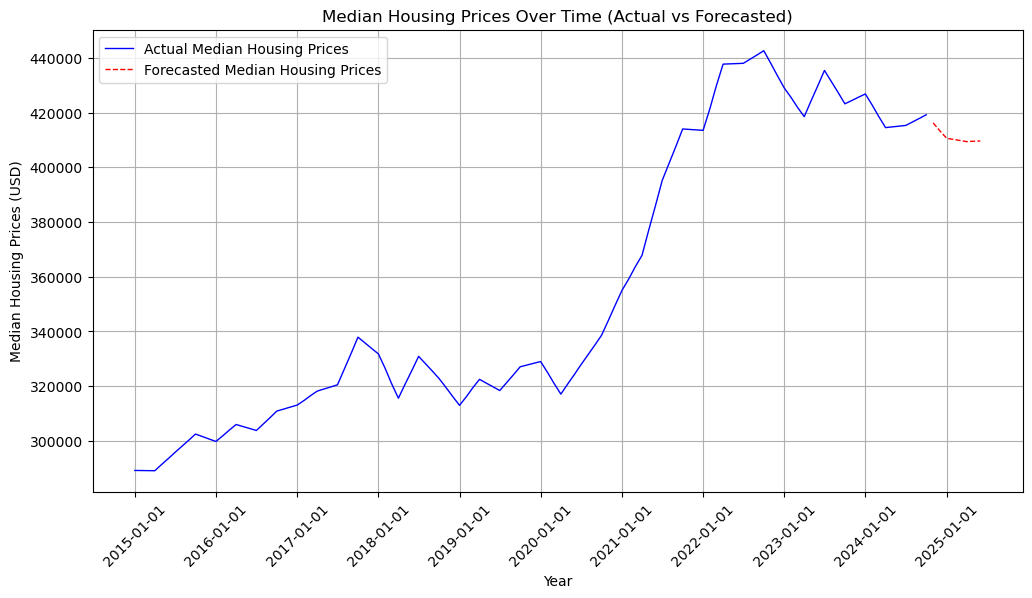

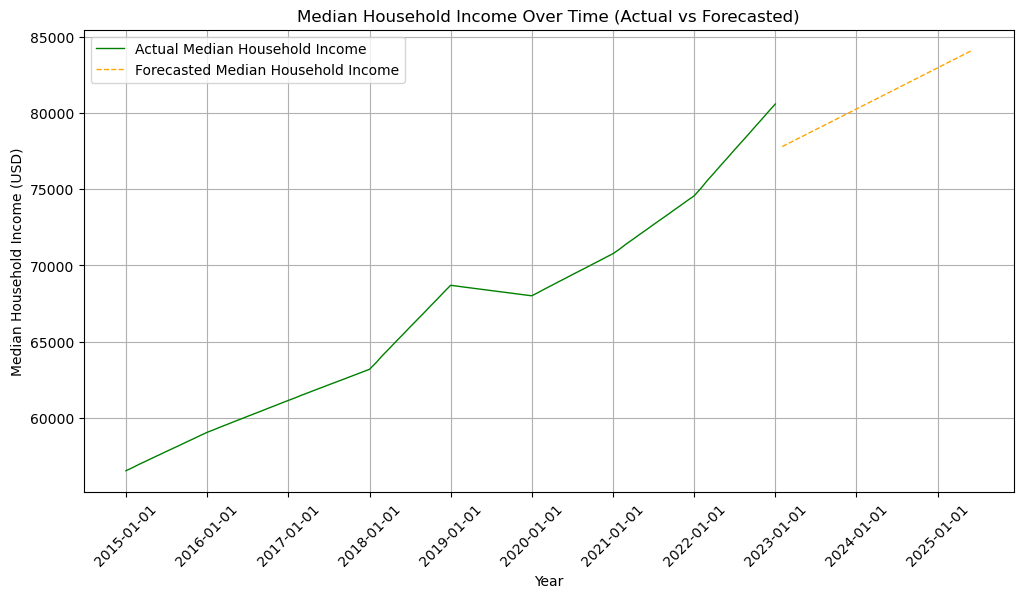

In [1141]:
#Plotting of the graphs for MHP and MHI separately
MHP['date'] = pd.to_datetime(MHP['date'])
MHI['date'] = pd.to_datetime(MHI['date'])
MHP_actual = MHP[MHP['date'] <= "2024-10-01"]
MHP_forecast = MHP[MHP['date'] > "2024-10-01"]
MHI_actual = MHI[MHI['date'] <= "2023-01-01"]
MHI_forecast = MHI[MHI['date'] > "2023-01-01"]

# Plot MHP
plt.figure(figsize=(12, 6))
plt.plot(MHP_actual['date'], MHP_actual['Median Housing Prices'], label="Actual Median Housing Prices", color="blue", linewidth=1)
plt.plot(MHP_forecast['date'], MHP_forecast['Median Housing Prices'], label="Forecasted Median Housing Prices", color="red", linestyle="dashed", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Median Housing Prices (USD)")
plt.title("Median Housing Prices Over Time (Actual vs Forecasted)")
plt.xticks(pd.date_range(start=MHP['date'].min(), end=MHP['date'].max(), freq='YS').to_pydatetime(), rotation=45)  # Show every year
plt.legend()
plt.grid(True)
plt.show()

# Plot MHI
plt.figure(figsize=(12, 6))
plt.plot(MHI_actual['date'], MHI_actual['Median Household Income'], label="Actual Median Household Income", color="green", linewidth=1)
plt.plot(MHI_forecast['date'], MHI_forecast['Median Household Income'], label="Forecasted Median Household Income", color="orange", linestyle="dashed", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Median Household Income (USD)")
plt.title("Median Household Income Over Time (Actual vs Forecasted)")
plt.xticks(pd.date_range(start=MHI['date'].min(), end=MHI['date'].max(), freq='YS').to_pydatetime(), rotation=45)  # Show every year
plt.legend()
plt.grid(True)
plt.show()

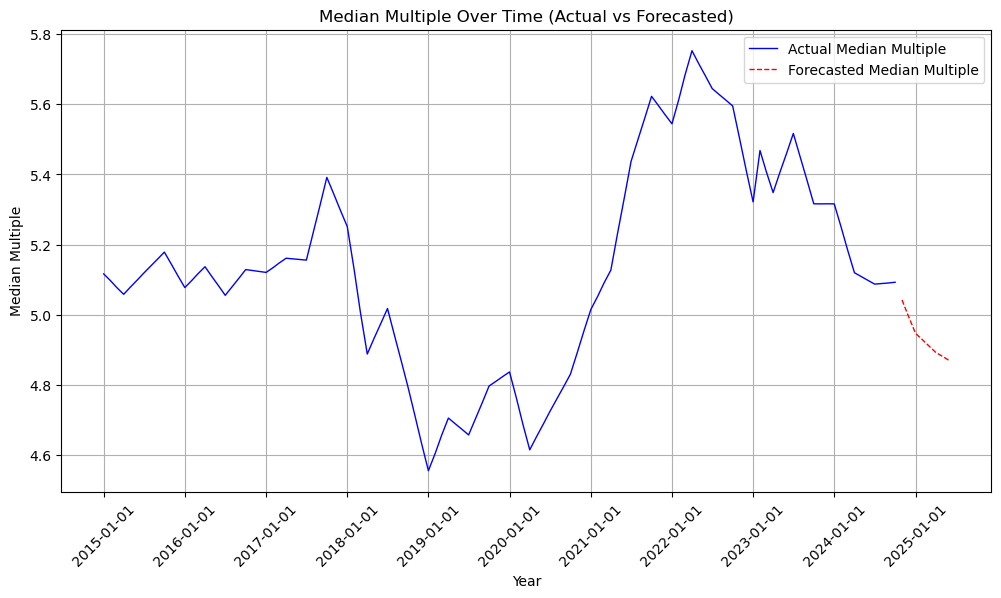

In [1143]:
#Plot the data for median multiple
# Ensure 'date' column is in datetime format
MMP['date'] = pd.to_datetime(MMP['date'])

# Separate actual and forecasted data (assuming forecast starts after 2024-10-01)
MMP_actual = MMP[MMP['date'] <= "2024-10-01"]
MMP_forecast = MMP[MMP['date'] > "2024-10-01"]

# Plot Median Multiple
plt.figure(figsize=(12, 6))
plt.plot(MMP_actual['date'], MMP_actual['Median Multiple'], label="Actual Median Multiple", color="blue", linewidth=1)
plt.plot(MMP_forecast['date'], MMP_forecast['Median Multiple'], label="Forecasted Median Multiple", color="red", linestyle="dashed", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Median Multiple")
plt.title("Median Multiple Over Time (Actual vs Forecasted)")
plt.xticks(pd.date_range(start=MMP['date'].min(), end=MMP['date'].max(), freq='YS').to_pydatetime(), rotation=45)  # Show every year
plt.legend()
plt.grid(True)
plt.show()

          date  30-Year Mortgage Rate  10-Year Treasury Yield  Mortgage Spread
115 2024-08-01                  6.500                  3.9260         2.574000
116 2024-09-01                  6.180                  3.7325         2.447500
117 2024-10-01                  6.428                  4.1040         2.324000
118 2024-11-01                  6.805                  4.3900         2.413333
119 2024-12-01                  6.715                  4.4100         2.305000


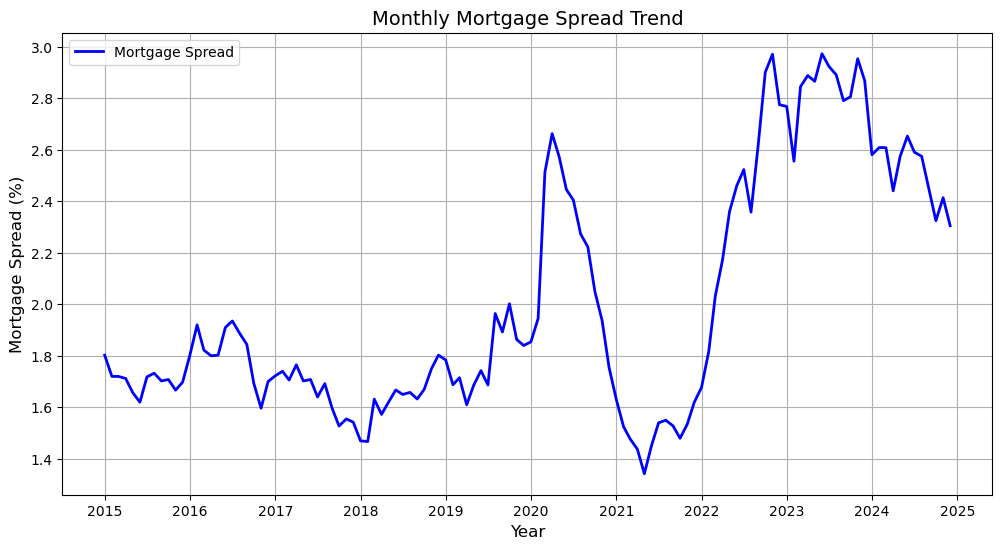

In [377]:
#Moving on to mortgage spreads, to calculate for it, we need to first fit the data for the 30Y mortgage rate 
# and for the 10 year treasury yield data and find the difference
#Interpolation and extrapolation of data is done up to June 2025 as specified above 
#30-year mortgage rate data
mortg30Y = pd.read_csv("/Users/benwong/Downloads/point72casestudy/US30Ymortgagerates.csv")
mortg30Y = mortg30Y.rename(columns={"observation_date": "date", "MORTGAGE30US": "30-Year Mortgage Rate"})
mortg30Y['date'] = pd.to_datetime(mortg30Y['date'])
mortg30ylast10 = mortg30Y.loc[(mortg30Y['date'] >= "2015-01-01") & (mortg30Y['date'] <= "2024-12-31")]
mortg30ylast10 = mortg30ylast10.reset_index(drop=True)

#10-year Treasury yield data
tyield10y = pd.read_csv("/Users/benwong/Downloads/point72casestudy/10yeartreasuryyields.csv")
tyield10y = tyield10y.rename(columns={"observation_date": "date", 'DGS10': '10-Year Treasury Yield'})
tyield10y['date'] = pd.to_datetime(tyield10y['date'])
tyield10y = tyield10y.set_index('date').resample('W-THU').last().reset_index()
merged_df = mortg30ylast10.merge(tyield10y, on='date', how='left')

#mortgage spread calculation
merged_df['Mortgage Spread'] = merged_df['30-Year Mortgage Rate'] - merged_df['10-Year Treasury Yield']
merged_df = merged_df[['date', '30-Year Mortgage Rate', '10-Year Treasury Yield', 'Mortgage Spread']]
merged_df.to_csv("/Users/benwong/Downloads/point72casestudy/mortgage_spread.csv", index=False)
merged_df = merged_df.set_index('date')  # Set date as index before resampling
monthly_avg = merged_df.resample('MS').mean()
df_monthly = monthly_avg 
df_monthly = df_monthly.reset_index()
df_monthly.to_csv("/Users/benwong/Downloads/point72casestudy/mortgage_spread_monthly.csv", index=False)
print(df_monthly.tail())

# Graph plotted for monthly mortgage spreads to decide what type of regression to use
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['date'], df_monthly['Mortgage Spread'], label="Mortgage Spread", color="blue", linewidth=2)
plt.title("Monthly Mortgage Spread Trend", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mortgage Spread (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

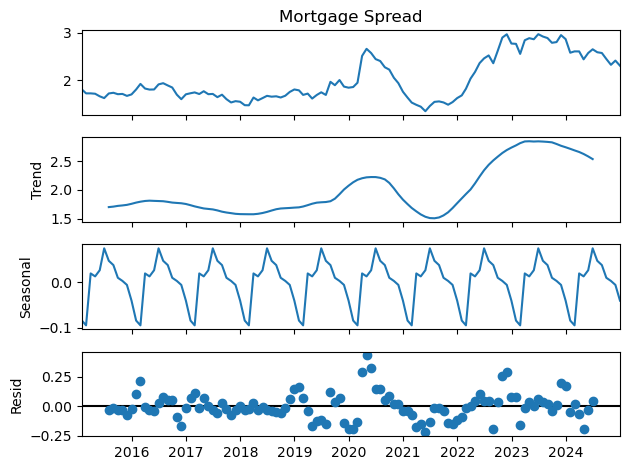

In [371]:
#When observing the data provided, I felt that SARIMA/ARIMA test was better at modelling both the long term trend and 
#cyclic nature of the mortgage spreads. They tend to exhibit seasonal patterns as there are typical home buying seasons 
# and interest rate cycles (due to economic cycles)
# Hence to confirm that there is seasonality within the data we will run a seasonality decomposition test
# seasonality test
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
df_monthly = pd.read_csv("mortgage_spread_monthly.csv")
df_monthly['date'] = pd.to_datetime(df_monthly['date'])
df_monthly.set_index('date', inplace=True)
decomp = seasonal_decompose(df_monthly['Mortgage Spread'], model='additive', period=12)
decomp.plot()
plt.show()

In [436]:
from statsmodels.tsa.stattools import adfuller
# Then, we perform ADF test to determine if stationary to see if differencing of data is required
result = adfuller(df_monthly['Mortgage Spread'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Data is non-stationary. Will have to do differencing.")
else:
    print("Data is stationary.")

ADF Statistic: -1.649587759692199
p-value: 0.45725542919813955
Data is non-stationary. Will have to do differencing.


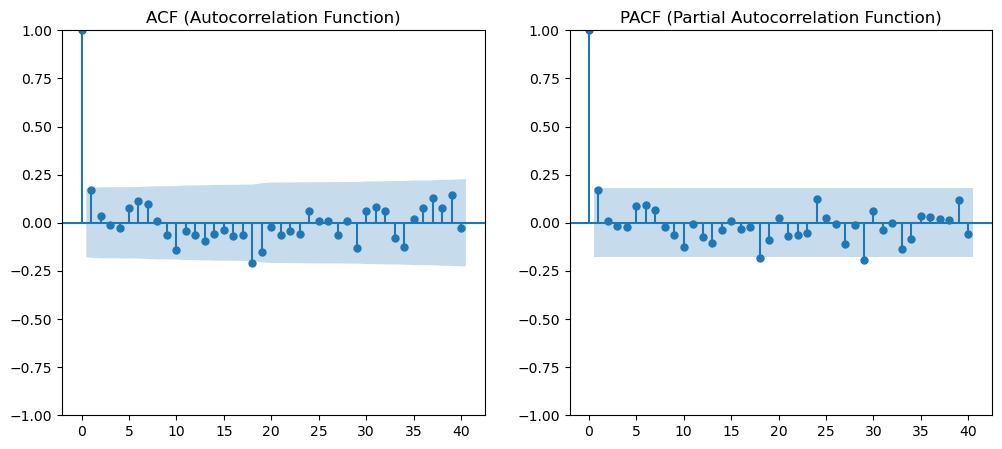

In [492]:
#Differencing in SARIMA has to be done as data is non-stationary
import matplotlib.pyplot as plt
# First, difference the data if needed (to make it stationary)
df_diff = df_monthly['Mortgage Spread'].diff().dropna()
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_acf(df_diff, ax=axes[0], lags=40)
axes[0].set_title("ACF (Autocorrelation Function)")
plot_pacf(df_diff, ax=axes[1], lags=40)
axes[1].set_title("PACF (Partial Autocorrelation Function)")
plt.show()

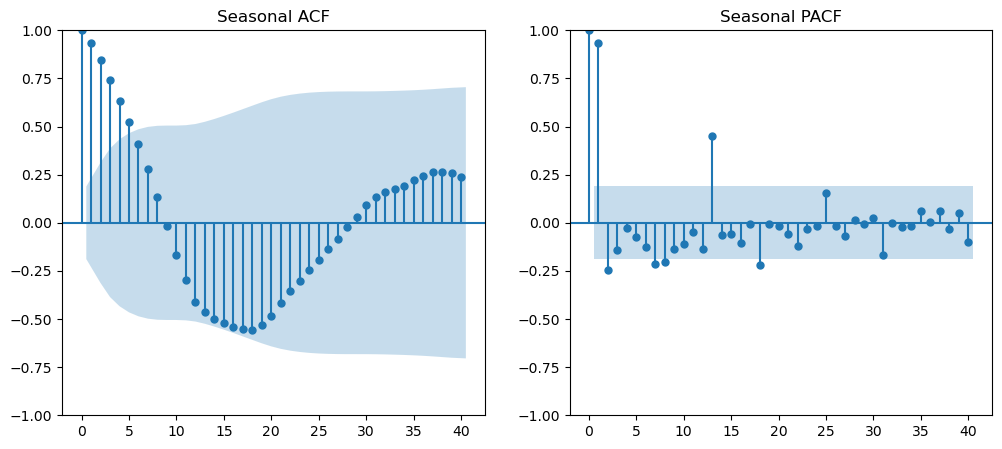

In [494]:
# Initially, I wanted to automatically find the best SARIMA model by using the inbuilt function in the pmdarima library
# what it does is that it performs a stepwise search by iterating through different outcomes of (p, d, q) x (P, D, Q, s)
# looking for the one that has the lowest Akaike Information Criterion (AIC) score
# before returning the best refitted model but it did not work and gave me a bad model (0,1,0)(0,0,0) 
# Since the optimal model did not make sense, I went to see the ACF and PACF plots below and 
# decided on choosing the current set of parameters (1,1,1)(1,1,1,12) for my manual sarima model to experiment
# To conclude from above, since ACF shows a significant spike at lag 1 and no significant spikes beyond lag 1
# We can conclude that there is a presence of a moving average component with q=1
# Since gradual decay for ACF does not exist, we can conclude that d=1 is sufficient
# PACF also shows a strong spike at lag 1 and cuts off after that, suggesting an AR component with p=1.
# Now, we check for seasonal ACF/PACF for P,D,Q values
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Apply seasonal differencing (for monthly data, s=12)
df_seasonal_diff = df_monthly['Mortgage Spread'].diff(12).dropna()
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_acf(df_seasonal_diff, ax=axes[0], lags=40)
axes[0].set_title("Seasonal ACF")
plot_pacf(df_seasonal_diff, ax=axes[1], lags=40)
axes[1].set_title("Seasonal PACF")
plt.show()
# no clear cutoffs and strong seasonal pattern hence Q was actually uncertain, but i selected Q=1
# gradual decay hence D = 1
# PACF shows a sharp cutoff after lag 1, meaning a seasonal AR component P=1 is needed

In [500]:
#manual sarima test with the (1,1,1)x(1,1,1,12) model
import pmdarima as pm
df_monthly = df_monthly.asfreq('MS')
manualsarimamodel = sm.tsa.statespace.SARIMAX(df_monthly['Mortgage Spread'], 
                                         order=(1,1,1),  # Manually set p, d, q to this to experiment
                                         seasonal_order=(1,1,1,12),  # Manually set P, D, Q, s to this to experiment
                                         enforce_stationarity=True, 
                                         enforce_invertibility=True)

# Fit the manual SARIMA model
sarima_results = manualsarimamodel.fit(disp=False)

# Print Model Summary (for the manually defined model)
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    Mortgage Spread   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  66.999
Date:                            Sun, 23 Feb 2025   AIC                           -123.997
Time:                                    14:57:12   BIC                           -110.633
Sample:                                01-01-2015   HQIC                          -118.580
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2684      0.506      0.530      0.596      -0.724       1.260
ma.L1         -0.0927      0.497   

In [526]:
# However, when we analyse the SARIMA model summary with the parameters above, we notice a few things
# While variables like log likelihood are relatively reasonable
# the main problem arises where the residual heteroskadasticity was unstable
# P(H) < 0.05 hence, residual variance not stable
# hence in order to handle this heteroskadasticity, I had to apply a log transformation to the data 
# and monitor forecast CIs to ensure stability
df_monthly['Log_Mortgage_Spread'] = np.log(df_monthly['Mortgage Spread'])
# Fit SARIMA model on log-transformed data
sarima_model_log = sm.tsa.statespace.SARIMAX(df_monthly['Log_Mortgage_Spread'], 
                                             order=(0,1,0),  
                                             seasonal_order=(0,1,1,12),  
                                             enforce_stationarity=True,  
                                             enforce_invertibility=True)
sarima_results_log = sarima_model_log.fit(disp=False)
print(sarima_results_log.summary())

                                      SARIMAX Results                                       
Dep. Variable:                  Log_Mortgage_Spread   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 144.271
Date:                              Sun, 23 Feb 2025   AIC                           -284.542
Time:                                      15:59:21   BIC                           -279.197
Sample:                                  01-01-2015   HQIC                          -282.375
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9743      0.907     -1.074      0.283      -2.752       0.803
sigma2         0.00

In [516]:
#from the summary, this model itself has a P(H) > 0.07, implying no significant heteroskedascity
#variance of residuals more stable ==> good
#variables were not normally distributed (P(JB) < 0.05) ==> bad
#ma.s12 = 0.283 => not statistically significant
#sigma2 = 0.226 => not statistically significant
#hence i tried to alter the Q value to 0 to try and improve these issues but
#heteroskadsicity actually worsens for this model(0, 1, 0)(0, 1, 0, 12) and AIC became higher than the previous model
#hence weighing all the different indicators/factors, I decided to use (0, 1, 0)(0, 1, 1, 12) instead 
#as it had better heteroskadiscity and AIC was lower ==> hence the better model
#so i figured that the problem lies elsewhere. Then i tried to fit SARIMA model on log-transformed data
sarima_model_log = sm.tsa.statespace.SARIMAX(df_monthly['Log_Mortgage_Spread'], 
                                             order=(0,1,0),  
                                             seasonal_order=(0,1,0,12),  
                                             enforce_stationarity=True,  
                                             enforce_invertibility=True)

sarima_results_log = sarima_model_log.fit(disp=False)
print(sarima_results_log.summary())
#But the log transformed data did not fix the normal distribution issue with the residuals and it made Q no longer significant
#I then tried removing the Q (by changing it to 0) but it worsened the model as the residuals now showed
#autocorrelation (P(Q)<0.05) and residual variance once again became unstable ((P(H) <0.05)

                                     SARIMAX Results                                      
Dep. Variable:                Log_Mortgage_Spread   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 112.792
Date:                            Sun, 23 Feb 2025   AIC                           -223.584
Time:                                    15:43:28   BIC                           -220.911
Sample:                                01-01-2015   HQIC                          -222.500
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0071      0.001      8.374      0.000       0.005       0.009
Ljung-Box (L1) (Q):                

                                      SARIMAX Results                                       
Dep. Variable:               BoxCox_Mortgage_Spread   No. Observations:                  120
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 262.599
Date:                              Mon, 24 Feb 2025   AIC                           -521.199
Time:                                      01:48:05   BIC                           -515.853
Sample:                                  01-01-2015   HQIC                          -519.032
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9030      0.264     -3.420      0.001      -1.420      -0.386
sigma2         0.00

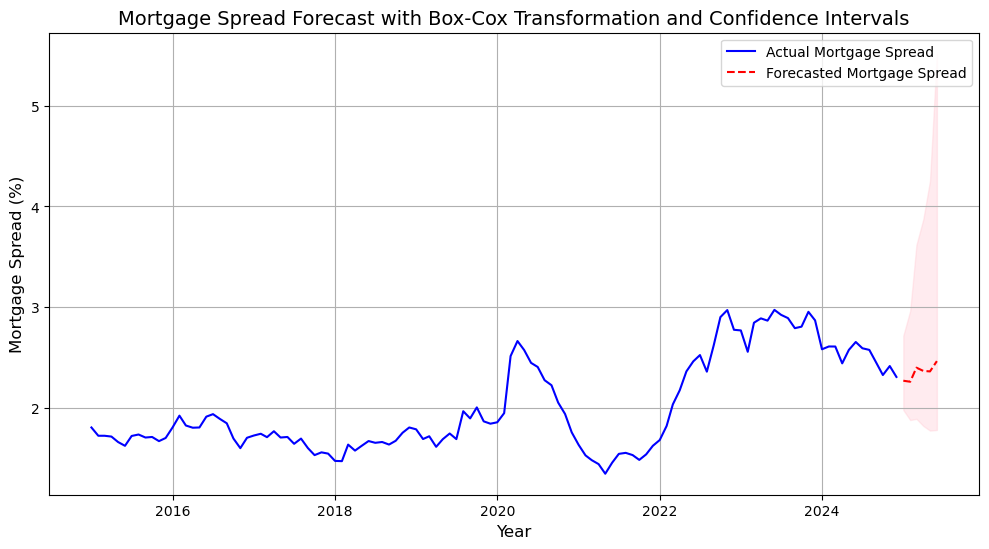

,date,Mortgage Spread
121,2025-02-01,2.257320
122,2025-03-01,2.397265
123,2025-04-01,2.364797
124,2025-05-01,2.360001
125,2025-06-01,2.462193


In [1155]:
#Hence after doing some research and experimenting, I ended up with boxcox transformed SARIMA model where it displayed 
#the lowest AIC  = -521.199
#Highly significant ma.S12 (0.001) and sigma2 (0.000)
#P(Q) = 0.08
#H = 0.67
#P(JB) = 0.11
#where normal distibution issues of the residuals and heteroskedacity were resolved.
#Hence, I decided that SARIMA(0,1,0)(0,1,1,12) with box-cox transformation was the best model for final forecasting
from scipy.stats import boxcox
df_monthly['BoxCox_Mortgage_Spread'], lambda_bc = boxcox(df_monthly['Mortgage Spread'])
sarima_model_bc = sm.tsa.statespace.SARIMAX(df_monthly['BoxCox_Mortgage_Spread'], 
                                             order=(0,1,0),  
                                             seasonal_order=(0,1,1,12),  
                                             enforce_stationarity=True,  
                                             enforce_invertibility=True)

sarima_results_bc = sarima_model_bc.fit(disp=False)
print(sarima_results_bc.summary())

# Generation of forecasts for the next 6 months (6 months to make the graph look nicer and to see if the trend looks accurate)
forecast_periods = 6
forecast_bc = sarima_results_bc.get_forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=df_monthly.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='MS')
forecast_mean = np.power((forecast_bc.predicted_mean * lambda_bc + 1), 1/lambda_bc)
forecast_conf_int = np.power((forecast_bc.conf_int() * lambda_bc + 1), 1/lambda_bc)

# Plotting the graph with the CIs
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, np.power((df_monthly['BoxCox_Mortgage_Spread'] * lambda_bc + 1), 1/lambda_bc), 
         label="Actual Mortgage Spread", color="blue")
plt.plot(forecast_index, forecast_mean, label="Forecasted Mortgage Spread", color="red", linestyle="dashed")
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Mortgage Spread Forecast with Box-Cox Transformation and Confidence Intervals", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mortgage Spread (%)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Prepare forecasted data for export
forecast_df = pd.DataFrame({'date': forecast_index, 'Mortgage Spread': forecast_mean})
forecast_df.set_index('date', inplace=True)
mortgagespread = pd.concat([df_monthly['Mortgage Spread'], forecast_df], axis=0)
mortgagespread = mortgagespread.reset_index()


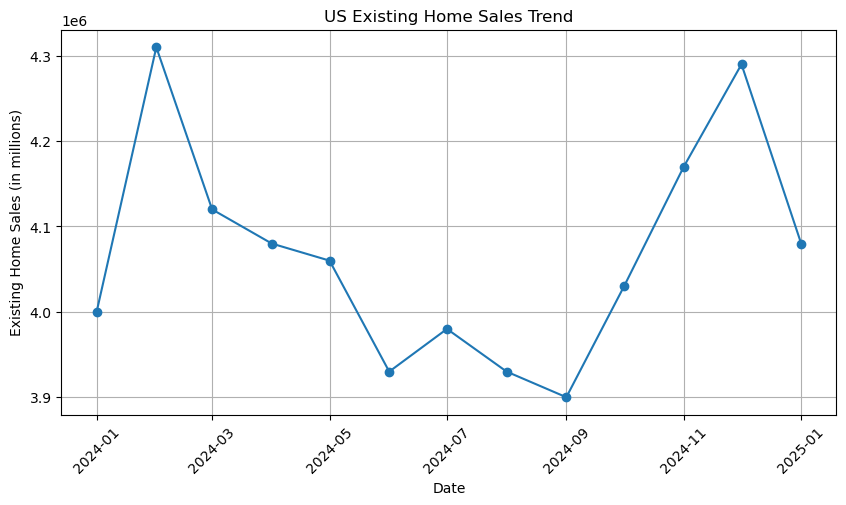

In [1245]:
# Moving onto US existing home sales, we will not be incorporating this set of data into our ML model
# as it only has monthly data for the past year. Firstly, it is insufficient data points and it will very easily lead to 
# overfitting if i performed extrapolation to the data 
# However, since home sales is an important point for consideration as it directly influences the demand for new houses
# thereby the demand for housing starts, I will graph it and mention it in my limitations and points for consideration 
df_home_sales = pd.read_csv("/Users/benwong/Downloads/point72casestudy/usexisitinghomesales.csv")
df_home_sales = df_home_sales.rename(columns={"observation_date": "date", "EXHOSLUSM495S": "Existing Home Sales"})
df_home_sales['date'] = pd.to_datetime(df_home_sales['date'])
df_home_sales.set_index('date', inplace=True)  # This removes the 'date' column and makes it an index

# Plot the existing home sales trend
plt.figure(figsize=(10, 5))
plt.plot(df_home_sales.index, df_home_sales['Existing Home Sales'], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("Existing Home Sales (in millions)")
plt.title("US Existing Home Sales Trend")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [1221]:
#Now concatenate the data together
df_merged['date'] = pd.to_datetime(df_merged['date'])
gdpwithforecast['date'] = pd.to_datetime(gdpwithforecast['date'])
zori_combined['date'] = pd.to_datetime(zori_combined['date'])
MMPfinal['date'] = pd.to_datetime(MMPfinal['date'])
mortgagespread['date'] = pd.to_datetime(mortgagespread['date'])
finaldf = df_merged.merge(gdpwithforecast, on='date', how='outer')
finaldf = finaldf.merge(zori_combined, on='date', how='outer')
finaldf = finaldf.merge(MMPfinal, on='date', how='outer')
finaldf = finaldf.merge(mortgagespread, on='date', how='outer')
finaldf = finaldf.sort_values(by="date").reset_index(drop=True)
finaldf.to_csv('/Users/benwong/Downloads/point72casestudy/combined final data/combined_final_data.csv', index=False)

In [1251]:
#goal here is to make use of a supervised machine learning model using all of the variables above 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
df = pd.read_csv("/Users/benwong/Downloads/point72casestudy/combined final data/combined_final_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')
df = df.drop(columns=['Migration', 'Existing Home Sales'], errors='ignore')
df = df.ffill()

#Creates lag features (Housing_Starts_Lag1, Lag2, Lag3) to incorporate past values of Total Housing Starts as predictors
#Capturing trends and momentum in housing starts needed for time-series forecasting
df['Housing_Starts_Lag1'] = df['Total Housing Starts'].shift(1)
df['Housing_Starts_Lag2'] = df['Total Housing Starts'].shift(2)
df['Housing_Starts_Lag3'] = df['Total Housing Starts'].shift(3)
df = df.dropna().reset_index(drop=True)

# Define predictors and target variable
target = "Total Housing Starts"
predictors = [col for col in df.columns if col not in ["date", target]]

# Split data into train-test sets (80% train, 20% test) to extract predictors and target variables separately
train_size = int(len(df) * 0.8)
train_df, test_df = df.iloc[:train_size], df.iloc[train_size:]
X_train, y_train = train_df[predictors], train_df[target]
X_test, y_test = test_df[predictors], test_df[target]

# Train Random Forest model to fit the model on the training data and helps the model learn the relationship
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
missing_rows = df[df['Total Housing Starts'].isna()]
if not missing_rows.empty:
    df.loc[df['Total Housing Starts'].isna(), 'Total Housing Starts'] = model.predict(missing_rows[predictors])

# Forecast Total Housing Starts up to June 2025
future_dates = pd.date_range(start="2025-02-01", periods=5, freq='MS')
future_df = pd.DataFrame({'date': future_dates})
last_known_values = df.iloc[-1][predictors].copy()
predictions = []
for _ in range(5):  
    predicted_value = model.predict([last_known_values])[0]
    predictions.append(predicted_value)
    last_known_values['Housing_Starts_Lag3'] = last_known_values['Housing_Starts_Lag2']
    last_known_values['Housing_Starts_Lag2'] = last_known_values['Housing_Starts_Lag1']
    last_known_values['Housing_Starts_Lag1'] = predicted_value
future_df['Total Housing Starts'] = predictions

          date  Total Housing Starts
108 2024-04-01              1377.000
109 2024-05-01              1315.000
110 2024-06-01              1329.000
111 2024-07-01              1262.000
112 2024-08-01              1379.000
113 2024-09-01              1355.000
114 2024-10-01              1344.000
115 2024-11-01              1305.000
116 2024-12-01              1515.000
117 2025-01-01              1366.000
123 2025-02-01              1507.030
124 2025-03-01              1494.455
125 2025-04-01              1493.985
126 2025-05-01              1497.410
127 2025-06-01              1497.745


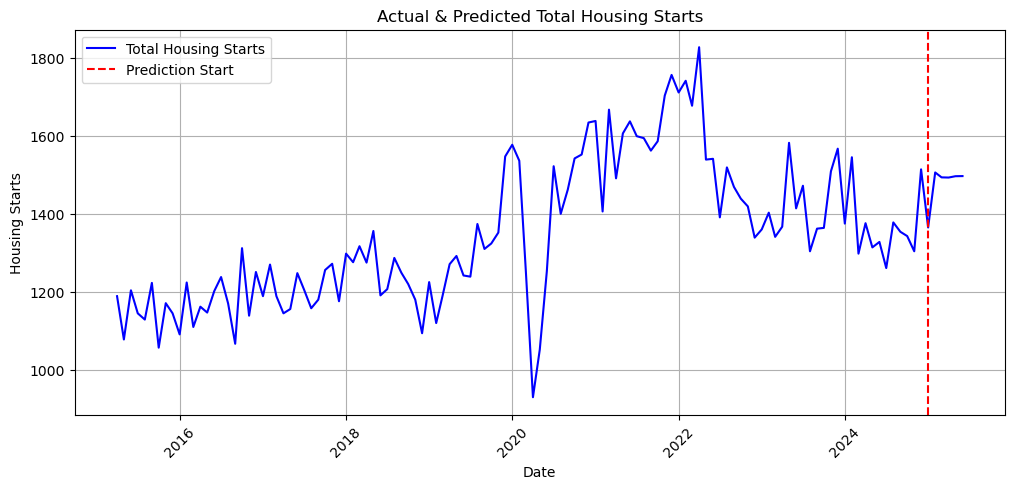

In [1237]:
# Combine actual and predicted data for visualization
df_extended = pd.concat([df[['date', 'Total Housing Starts']], future_df], ignore_index=True)
df_extended = df_extended.drop_duplicates(subset=['date'], keep='last')
print(df_extended.tail(15))
plt.figure(figsize=(12, 5))
plt.plot(df_extended['date'], df_extended['Total Housing Starts'], label="Total Housing Starts", color="blue")
plt.axvline(x=pd.Timestamp("2025-01-01"), color='red', linestyle='dashed', label="Prediction Start")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Housing Starts")
plt.title("Actual & Predicted Total Housing Starts")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [1253]:
#Therefore the predicted value is as shown below:
print("Forecasted Total Housing Starts (Jan 2025 - Jun 2025):")
print(df_extended.tail(10))

Forecasted Total Housing Starts (Jan 2025 - Jun 2025):
          date  Total Housing Starts
113 2024-09-01              1355.000
114 2024-10-01              1344.000
115 2024-11-01              1305.000
116 2024-12-01              1515.000
117 2025-01-01              1366.000
123 2025-02-01              1507.030
124 2025-03-01              1494.455
125 2025-04-01              1493.985
126 2025-05-01              1497.410
127 2025-06-01              1497.745


In [1]:
#MAE AND R2 test to see reliability of prediction
from sklearn.metrics import mean_absolute_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

NameError: name 'model' is not defined